# AWD-LSTM from scratch:

Text generation is the task of producing new text from a given input prompt. An example of text generation using machine learning is `GitHub’s Copilot`, which can generate code. Apart from code generation, text generation models can:

1. Generate stories, for example, try passing “Once upon a time " as input to a GPT-2 model.
2. Generate poetry.
3. Complete a paragraph with missing sentences. 
4. Summarize an article.
5. Answer questions given some context.

And many more...

In this notebook, we train AWD-LSTM for the task of story generation. We do so by training a causal language model.  A causal language model tries to predict the next token in a given input sequence. In this way, it builds an understanding of the data it is trained on. 

__Agenda__:

1. Load the dataset from csv files
2. Tokenize and preprocess text
3. Create Batches
4. Fine-tune AWD-LSTM model 
5. Evaluate trained model





## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/nlp

/content/gdrive/My Drive/nlp


In [ ]:
!ls

ai-story_gen  models			 story_gpt2
data	      story_distilgpt2_finetune  story_gpt2_finetune


## Parameters for notebook execution:

It's better to store all the parameters we need for a successful execution in one place. This way it's easy to manage the parameters. 

In [ ]:
import os 

# current directory path
DIR_PATH=os.getcwd()

In [ ]:
DIR_PATH

'/content/gdrive/My Drive/nlp'

In [ ]:
# parameters

# SAMPLE
TRAIN_ROWS=50000
TEST_ROWS=5000

# PATH OF CSV FILES
TRAIN_PATH= DIR_PATH+"/data/train_df.csv"
VALID_PATH=DIR_PATH+"/data/valid_df.csv"
TEST_PATH= DIR_PATH+"/data/test_df.csv"

# DATA PROCESSING
CONTEXT_LEN=256

# HYPERPARAMETERS
TRAIN_BS= 64
TEST_BS= 64 
EPOCHS=5

## Load the data

In [ ]:
# import required libraries
from fastai.text.all import *
import pandas as pd

First, let's load the dataframes

In [ ]:
# load the data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
valid_df = pd.read_csv(VALID_PATH)

Let's drop the unecessary columns:
- `Unnamed: 0`
- `prompts`


In [ ]:
train_df.drop(columns=['Unnamed: 0', 'prompts'], inplace=True)
test_df.drop(columns=['Unnamed: 0', 'prompts'], inplace=True)
valid_df.drop(columns=['Unnamed: 0', 'prompts'], inplace=True)

Selecting a subset of the data

In [ ]:
train_df = train_df.sample(n=TRAIN_ROWS, random_state=42)
valid_df = valid_df.sample(n=TEST_ROWS, random_state=42)

# test_df = test_df[:600]

`Fastai` requires us to tell it whether the data is coming from the training set or the testing set. So, we need to create a `is_valid` column which tells us whether the row represents data from the training set or the validation set. 

In [ ]:
train_df['is_valid']=False
valid_df['is_valid']=True

In [ ]:
valid_df.head(3)

,stories,is_valid
4462,"*Energy core online . Initializing start-up sequence . Optic sensors online . * <newline> <newline> Light . It always started with light . And then ... <newline> <newline> *Activating motor function . Radar online . Weapons system online . Downloading combat data . Prepare for war . * <newline> <newline> And then chaos . I stepped away from my constraints , eyes already searching the battlefield for enemy Spectres- mass produced , dumb AI whose only purpose was to destroy the plastic bodies of the enemy- gun at the ready . As the battle went on , one side would push toward the enemy , unti...",True
8719,"Esar flicked his tail nervously as he prepared to walk onstage . After years in the field , working in the frigid cold of the lower continent and the scorching heat of deserts he was finally ready to report his findings to the world . Esar had spoken before massive crowds before , but this time was different , this time he would be changing his people 's entire view of the world . <newline> Then the clipboard wielding assistant motioned for him to go on , Esar gulped , then walked forward . <newline> `` Ladies and gentlemen ! '' He proclaimed to the audience . `` Today I am here to announc...",True
9380,"Everyone sat silently in the darkened living room . The only sound that permeated through the darkness was the ticking of Mom 's old grandfather clock in the other room . Chris lost track of time after a few minutes . Or was it a few hours ? The clock dinged without warning . He counted eleven dings before it went back to it 's usual ticking . <newline> <newline> It is 11 P.M. and Dad will be getting home shortly . That 's the time he usually gets home , anyway , because that 's when he swings by the liquor stores right before they close . <newline> <newline> `` Thank you , everyone , for ...",True


Ok!!! Now, let's concatenate these two dataframes. 

In [ ]:
all_df = pd.concat([train_df, valid_df],ignore_index=True)

In [ ]:
all_df.sample(n=4)

,stories,is_valid
40468,"Keller , <newline> <newline> It 's time . We got ta do this tonight , or what else can we do ? The boss plans to increase production tomorrow morning , capturing more of those members in the rebellion . They 'll be sucked dry for plasma , and they 'll be no more hope to help anyone . <newline> <newline> I know that you 're hesitant about this . I am too . But we have to help , or do something that 'll change this damn system . Your wife is one of those `` birthers '' now , used as a breeder for babies to empty out like a glass of milk . Do you want her to suffer longer in that hellhole ? T...",False
52570,"“ Ingenuity draws its roots deep in the loam of understanding , my new apprentice , ” the wizard Khadaras began , one eye studying his first and only student , her plump body planted on a lone stump in a withered hollow , Khadaras ’ s home . “ And my kin , in their abject conceit , have misunderstood this simple truth . They seek the knowledge of history , the works and writings of their great forebearers . And how they suffer from such ignorance. ” <newline> <newline> “ Surely , Master Khadaras , history can lend to understanding and thus offer a fertile soil for one ’ s ingenuity to deve...",True
35165,"Sonnet Number Seventy-Two <newline> <newline> Our words are equal measure to our lives <newline> In length and time where every man alive <newline> Can choose his paragraph before he dies <newline> But will then for communication strive . <newline> <newline> A morbid mob will always crowd around <newline> A man who 's spoken anything , because <newline> The weight of words is such , it needs a crowd <newline> To witness dying breaths of life in pause . <newline> <newline> Without expression , all live inner worlds <newline> But break through once , before untimely death <newline> To speak ...",False
29824,"I took a stab at it while at work ! No spell check because I 'm dyslexic and wrote it in notepad over the last two or so hours ! <newline> <newline> ***** <newline> <newline> Walking through a forest , a group of adventurers sat amungst some rocks around a small fire as they discussed their haul for todays hunt . <newline> <newline> Jerry , a Page in the Paladin 's guard , sat on the largest rock . `` I ca n't believe that all that Goblin Mage had was some paper and this weird , 20 sided die '' <newline> <newline> `` I know , right ? I do n't know what we should do with it . I kept it thou...",False


## Creating DataBlock and dataloaders:

In the last section, we loaded the data. Now, in this section, we will create the `DataBlock` and `Dataloaders` for the text data. 

In [ ]:
dsets= DataBlock(blocks=TextBlock.from_df('stories',min_freq=3,is_lm=True),
                    get_x=ColReader('text'),
                    splitter=ColSplitter())

In [ ]:
dls = dsets.dataloaders(source=all_df,bs=TRAIN_BS,seq_len=CONTEXT_LEN)

Let's see some examples from the dataloader. 

In [ ]:
dls.show_batch(max_n=5)

,text,text_
0,"xxbos 1963 – xxmaj united xxmaj states of xxmaj america ; xxmaj new xxmaj york xxmaj office of xxmaj immigration < newline > < newline > xxmaj the older xxmaj japanese man sighed and leaned forward , supporting himself on his cane . xxmaj he cleared his throat and looked around , taking in his surroundings . a few people bustled to and fro behind the counter at the immigration office , but outside of himself and another elderly gentleman sitting to his left , there was no one else waiting to be served . < newline > < newline > xxmaj clearing his throat , he decided to practice his xxmaj english a bit . xxmaj he had studied xxmaj english extensively prior to the war , and had served as an intelligence officer in the xxmaj second xxmaj world xxmaj war . xxmaj as such , his xxmaj","1963 – xxmaj united xxmaj states of xxmaj america ; xxmaj new xxmaj york xxmaj office of xxmaj immigration < newline > < newline > xxmaj the older xxmaj japanese man sighed and leaned forward , supporting himself on his cane . xxmaj he cleared his throat and looked around , taking in his surroundings . a few people bustled to and fro behind the counter at the immigration office , but outside of himself and another elderly gentleman sitting to his left , there was no one else waiting to be served . < newline > < newline > xxmaj clearing his throat , he decided to practice his xxmaj english a bit . xxmaj he had studied xxmaj english extensively prior to the war , and had served as an intelligence officer in the xxmaj second xxmaj world xxmaj war . xxmaj as such , his xxmaj english"
1,"absence . xxmaj it is that order which preserves our society today . xxmaj it is that order that brings us the nourishment humanity requires to be productive in a perfect society . xxmaj and we invite everyone to join our great society ! < newline > < newline > xxmaj even the specimens have their part , as they are the foundation upon which our cities are built . xxmaj they provide the production to accomplish menial tasks not fit for us , as well as the meat that sustains us . xxmaj our ancestors made sure that , despite the lack of nutrition available in the xxmaj early xxmaj years , that we would have the food necessary to survive . xxmaj without that vision , our society would perish . xxmaj every specimen parent - pair is required to bear at least two children -- one to",". xxmaj it is that order which preserves our society today . xxmaj it is that order that brings us the nourishment humanity requires to be productive in a perfect society . xxmaj and we invite everyone to join our great society ! < newline > < newline > xxmaj even the specimens have their part , as they are the foundation upon which our cities are built . xxmaj they provide the production to accomplish menial tasks not fit for us , as well as the meat that sustains us . xxmaj our ancestors made sure that , despite the lack of nutrition available in the xxmaj early xxmaj years , that we would have the food necessary to survive . xxmaj without that vision , our society would perish . xxmaj every specimen parent - pair is required to bear at least two children -- one to carry"
2,"back to my apartment , switched it on and then suddenly it 's there : one folder , right in the centre , with a name that made me so hesitant to open it … ` ` xxmaj hell '' . < newline > < newline > i knew i was probably just being stupid , i mean what 's the worst that could happen , right ? xxmaj but i ' ve read about loads of these computers being sold with viruses and all sorts of evil tech stuff , and something called ' hell ' does n't sound too reassuring . i ' ve never been one to trust these things , i thought about opening it and just seeing what 's there - maybe laugh at the empty folder with the spooky name that managed to scare a 30 year old man , but i thought i","to my apartment , switched it on and then suddenly it 's there : one folder , right in the centre , with a name that made me so hesitant to

## Training the Model:
After the data processing is done, we need to train the model. 

In [ ]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]
    ).to_fp16()

In [ ]:
learn.model.reset()

SuggestedLRs(valley=0.0030199517495930195)

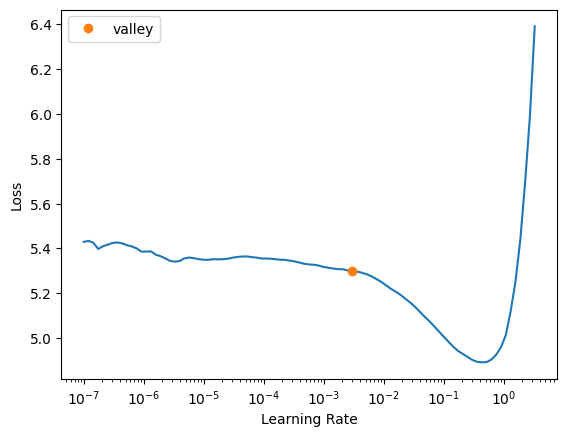

In [ ]:
# find the optimal learning rate
learn.lr_find()

In [ ]:
# train the language model
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.598574,3.509174,0.357766,33.420654,18:55
1,3.498349,3.457401,0.362493,31.734377,19:11


In [ ]:
# learn.unfreeze()
learn.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.243922,3.248430,0.390154,25.749882,19:01


In [ ]:
learn.save("story_awd_lstm")

Path('models/story_awd_lstm.pth')

## Story Generation:

In [ ]:
learn.load("story_awd_lstm")

In [ ]:
TEXT = "i like pizza"
N_WORDS = 100
N_SENTENCES = 1
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print('\n'.join(preds))

i like pizza , i have a really good time here . i can ’ t go inside and i ’ ll be there for my usual birthday tomorrow . For example i ’ ve always been a hero . And i just wanted to not last . i ’ m Adam Sandler . The hero . i have a big year , i ’ ll be happy . < newline > < newline > Funny about you the first time that i got a job . It all happened when i first met her .


### Finally let's evaluate our language model:

The evaluation of a text generation task can be subjective and depend on the specific goals of the task. However, there are several common methods that can be used to evaluate the quality of the generated text.

1. __Human evaluation:__ One of the most reliable methods for evaluating text generation is through human evaluation. This involves having human evaluators read the generated text and rate its quality based on various metrics such as coherence, fluency, and relevance to the prompt or topic. This method provides a subjective evaluation of the text and can give insights into how well the generated text matches human writing.

2. __Automated metrics:__ Automated metrics can be used to evaluate text generation based on various quantitative measures. Examples of automated metrics include perplexity, BLEU score, and ROUGE score. These metrics compare the generated text to a reference text or corpus, and provide a measure of the similarity between the two texts.

3. __Domain-specific metrics:__ For text generation tasks that are focused on a specific domain, such as medical or legal writing, domain-specific metrics can be used to evaluate the quality of the generated text. These metrics are designed to measure the accuracy and completeness of the generated text within the specific domain.

4. __User testing:__ In some cases, user testing can be used to evaluate the quality of the generated text. This involves having users interact with the generated text and providing feedback on its quality, usefulness, and relevance to the task or topic.

__Perplexity__

In [ ]:
valid_perplexity = learn.validate()[2]

In [ ]:
valid_perplexity

25.749881744384766